# Identify Damaged Car Parts with Vertex AutoML

## Overview
Vertex AI brings together the Google Cloud services for building ML under one, unified UI and API. In Vertex AI, you can now easily train and compare models using [AutoML](https://cloud.google.com/vertex-ai/docs/beginner/beginners-guide/) or custom code training and all your models are stored in one central model repository. These models can now be deployed to the same endpoints on Vertex AI.

AutoML Vision helps anyone with limited Machine Learning (ML) expertise train high quality image classification models. In this hands-on lab, you will learn how to produce a custom ML model that automatically recognizes damaged car parts.

Once you’ve produced your ML model, it’ll be immediately available for use. You can use the UI or the REST API to start generating predictions directly from the Google Cloud Console.

## Learning Objectives
In this lab, you learn how to:
- Upload a labeled dataset to Cloud Storage using a CSV file and connect it to Vertex AI as a Managed Dataset
- Inspect uploaded images to ensure there are no errors in your dataset
- Launch an AutoML Training Job
- Review your trained model and evaluate its accuracy
- Deploy a trained model and try online prediction


## Setup

In [15]:
import base64
import csv
import os

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic.schema import predict

## Upload training images to Cloud Storage
In this task you will upload the training images you want to use to Cloud Storage. This will make it easier to import the data into Vertex AI later.

To train a model to classify images of damaged car parts, you need to provide the machine with labeled training data. The model will use the data to develop an understanding of each image, differentiating between car parts and those with damages on them.

In this example, your model will learn to classify five different damaged car parts: **bumper**, **engine compartment**, **hood**, **lateral**, and **windshield**.


### Create a Cloud Storage bucket
To start, open a new Cloud Shell window and execute the following commands to set some environment variables:



In [7]:
PROJECT_ID = !(gcloud config get-value project)
PROJECT_ID = PROJECT_ID[0]
BUCKET = PROJECT_ID

Next, to create a Cloud Storage bucket, execute the following command:


In [ ]:
!gsutil mb -p {PROJECT_ID} \
    -c standard \
    -l us-central1 \
    gs://{BUCKET}

### Upload car images to your Storage Bucket
The training images are publicly available in a Cloud Storage bucket. Again, copy and paste the script template below into Cloud Shell to copy the images into your own bucket.

To copy images into your Cloud Storage bucket, execute the following command:



In [9]:
!gsutil -mq cp -r gs://asl-public/data/car_damage_lab_images* gs://{BUCKET}/car_damage_lab_images

Let's take a look at some samples.

mkdir: cannot create directory ‘./car_damage_lab_images’: File exists


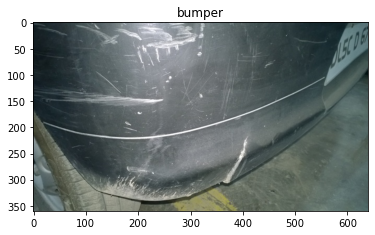

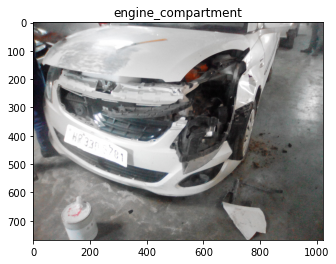

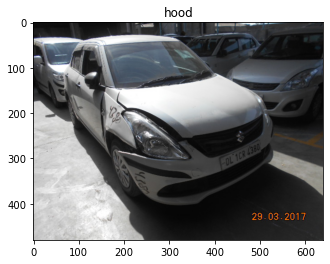

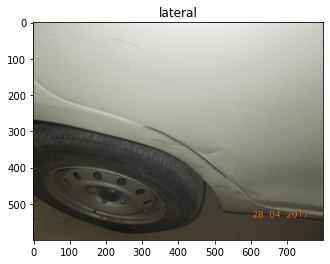

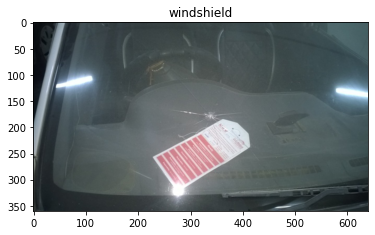

In [10]:
!mkdir ./car_damage_lab_images

LABELS = ["bumper", "engine_compartment", "hood", "lateral", "windshield"]
for label in LABELS:
    !gsutil -q cp gs://{BUCKET}/car_damage_lab_images/{label}/{label}1.jpg ./car_damage_lab_images
    img = mpimg.imread(f"car_damage_lab_images/{label}1.jpg")
    plt.imshow(img)
    plt.title(label)
    plt.show()

!rm -rf car_damage_lab_images

## Create a dataset
In this task, you create a new dataset and connect your dataset to your training images to allow Vertex AI to access them.

Let's create a CSV file where each row contains a URL to a training image and the associated label for that image.<br>
Also, optionally we can add a column which represent data split like `TRAIN` or `VALIDATION`.<br>

```
TRAIN, gs://bucket/img1.jpg, bumper
VALIDATION, gs://bucket/img2.jpg, hood
```

You can check the detail of CSV format in [the official document](https://cloud.google.com/vision/automl/object-detection/docs/csv-format).

In this case, labels for each image is represented as directory name. So we can create the csv in this command.

In [11]:
CSV_FILE = "car_damage_dataset.csv"

data_list = []

for label in LABELS:
    data = !gsutil ls gs://{BUCKET}/car_damage_lab_images/{label}
    for i, img_path in enumerate(data):
        assign = "TRAIN" if i % 5 > 0 else "VALIDATION"  # 80:20
        data_list.append([assign, img_path, label])

with open(CSV_FILE, "w") as f:
    write = csv.writer(f)
    write.writerows(data_list)

In [12]:
!head ./car_damage_dataset.csv

VALIDATION,gs://takumi-misc/car_damage_lab_images/bumper/bumper1.jpg,bumper
TRAIN,gs://takumi-misc/car_damage_lab_images/bumper/bumper10.jpg,bumper
TRAIN,gs://takumi-misc/car_damage_lab_images/bumper/bumper11.jpg,bumper
TRAIN,gs://takumi-misc/car_damage_lab_images/bumper/bumper12.jpg,bumper
TRAIN,gs://takumi-misc/car_damage_lab_images/bumper/bumper13.jpg,bumper
VALIDATION,gs://takumi-misc/car_damage_lab_images/bumper/bumper14.jpg,bumper
TRAIN,gs://takumi-misc/car_damage_lab_images/bumper/bumper15.jpg,bumper
TRAIN,gs://takumi-misc/car_damage_lab_images/bumper/bumper16.jpg,bumper
TRAIN,gs://takumi-misc/car_damage_lab_images/bumper/bumper17.jpg,bumper
TRAIN,gs://takumi-misc/car_damage_lab_images/bumper/bumper18.jpg,bumper


Let's upload this CSV file to the GCS bucket.

In [13]:
!gsutil cp ./{CSV_FILE} gs://{BUCKET}/car_damage_lab_images

Copying file://./car_damage_dataset.csv [Content-Type=text/csv]...
/ [1 files][  8.1 KiB/  8.1 KiB]                                                
Operation completed over 1 objects/8.1 KiB.                                      


## Create a managed dataset

Now let's import the data by specifying the csv file we created.

In [20]:
display_name = "damaged_car_parts"

ds = aiplatform.ImageDataset.create(
    display_name=display_name,
    gcs_source=f"gs://{BUCKET}/car_damage_lab_images/{CSV_FILE}",
    import_schema_uri=aiplatform.schema.dataset.ioformat.image.single_label_classification,
    sync=True,
)

INFO:google.cloud.aiplatform.datasets.dataset:Creating ImageDataset
INFO:google.cloud.aiplatform.datasets.dataset:Create ImageDataset backing LRO: projects/849204435784/locations/us-central1/datasets/8913322951961477120/operations/380030319941648384
INFO:google.cloud.aiplatform.datasets.dataset:ImageDataset created. Resource name: projects/849204435784/locations/us-central1/datasets/8913322951961477120
INFO:google.cloud.aiplatform.datasets.dataset:To use this ImageDataset in another session:
INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.ImageDataset('projects/849204435784/locations/us-central1/datasets/8913322951961477120')
INFO:google.cloud.aiplatform.datasets.dataset:Importing ImageDataset data: projects/849204435784/locations/us-central1/datasets/8913322951961477120
INFO:google.cloud.aiplatform.datasets.dataset:Import ImageDataset data backing LRO: projects/849204435784/locations/us-central1/datasets/8913322951961477120/operations/4514334777867763712
INFO:google.clou

**Note**: It will take around 9 to 12 minutes for your images to import and be aligned with their categories. You’ll need to wait for this step to complete before checking your progress.

## (Optional) Inspect images
When the upload job is done, you can check the dataset in the Vertex AI concole.

Please go to [the console](https://console.cloud.google.com), and navigate to  `Vertex AI` -> `Datasets` -> `damaged_car_parts`.

>![image](https://user-images.githubusercontent.com/6895245/175039729-f40ff31f-0a16-439a-97c3-fb29defbf16c.png)

## Check image labels

1. Under **Filter labels**, click any one of the labels to view the specific training images. *(Example: engine_compartment.)*

>![image](https://user-images.githubusercontent.com/6895245/175039977-61e7fcba-8750-4ac2-b8dd-50417f93c72c.png)

**Note: If you were building a production model, you'd want at least 100 images per label to ensure high accuracy. This is just a demo so only 20 images of each type were used so the model could train quickly.**


2. If an image is labeled incorrectly, you can click on it to select the correct label or delete the image from your training set:

>![image](https://user-images.githubusercontent.com/6895245/175040279-b82b7a0b-fabb-4db0-ab95-20c9ec1c7b06.png)</kbd>

3. Next, click on the **Analyze** tab to view the number of images per label. The Label Stats window appears on the right side of your browser.

>![image](https://user-images.githubusercontent.com/6895245/175040916-4d9cdc3b-f59e-4005-a5a1-9d11d49ad518.png)

**Note**: If you need help labeling your dataset, Vertex AI Labeling Services lets you work with human labelers to generate highly accurate labels.


## Train your model
You're ready to start training your model!

Vertex AI AutoML is a service that designs and builds machine learning models automatically.
So you don't need to write any of the model code. Instead, let's just use Python SDK to kick off training.

When we run training, we can specify the node hours based on the budget you have
For image classificaiton jobs, the minimum node hours is 8.

In [32]:
job = aiplatform.AutoMLImageTrainingJob(
    display_name=display_name,
    model_type="CLOUD",
    prediction_type="classification",
    multi_label=False,
)

In [33]:
model_display_name = "damaged_car_parts_model"

model = job.run(
    dataset=ds,
    model_display_name=model_display_name,
    budget_milli_node_hours=8 * 1000,  # 8 milli node hours
    sync=True,
)

INFO:google.cloud.aiplatform.training_jobs:No dataset split provided. The service will use a default split.
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4687952817854349312?project=849204435784
INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/849204435784/locations/us-central1/trainingPipelines/4687952817854349312 current state:
PipelineState.PIPELINE_STATE_PENDING
INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/849204435784/locations/us-central1/trainingPipelines/4687952817854349312 current state:
PipelineState.PIPELINE_STATE_PENDING
INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/849204435784/locations/us-central1/trainingPipelines/4687952817854349312 current state:
PipelineState.PIPELINE_STATE_PENDING
INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/849204435784/locations/us-central1/trainin

**Note**: Model training will take roughly 30 minutes to complete.

## Evaluate your model
In this task, you evaluate your model. Because it is a classification problem, we can see a lot of classification metrics.

1. Navigate to your newly trained model from `Vertex AI` -> `Model` -> `damaged_car_parts_model`. Click on the **Evaluate tab**. This tab displays information about Precision and Recall of the model. It should resemble the following:

>![image](https://user-images.githubusercontent.com/6895245/175043316-ccad262e-ac16-444f-a4bc-dcf96975bf4e.png)

2. You can also adjust the **Confidence threshold** slider to see its impact.

3. Scroll down to view the **Confusion matrix**.

>![image](https://user-images.githubusercontent.com/6895245/175046016-4cba9dc2-8040-4dc8-b6cf-2566856f5ab8.png)

This section provides some common machine learning metrics to help you evaluate your model’s accuracy and identify areas for improvement in your training data.


## Deploy to endpoint

Now let's deploy an model and call its prediction via API.

The [`model.deploy` function](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_deploy) deploys a model to Vertex AI to an endpoint.

You can specify an existing Vertex AI Endpoint, but if it is not set, it automatically creates a new endpoint.

**Note**: This can take up to 10 minutes to deploy.

In [49]:
endpoint = model.deploy(
    deployed_model_display_name="model_display_name_endpoint",
    min_replica_count=1,
    max_replica_count=1,
    accelerator_type=None,
    accelerator_count=None,
    sync=True,
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/849204435784/locations/us-central1/endpoints/3801416317500653568/operations/8533515970319220736
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/849204435784/locations/us-central1/endpoints/3801416317500653568
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/849204435784/locations/us-central1/endpoints/3801416317500653568')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/849204435784/locations/us-central1/endpoints/3801416317500653568
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/849204435784/locations/us-central1/endpoints/3801416317500653568/operations/5790823797250588672
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/84920443578

## Generate predictions
Now it's time for the most important part: generating predictions on your trained model using data it hasn't seen before.

There are a few ways to generate predictions. In this lab you'll use python command to call the deployed model and see how your model classifies the following images:

- Damaged bumper

- Damaged engine compartment

- Damage to the hood and the bumper. (Note: This last image is a good candidate for a multi-label classification problem)


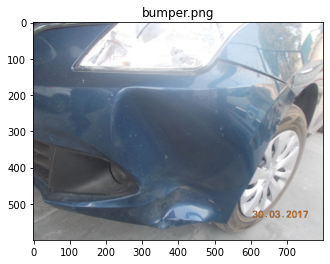

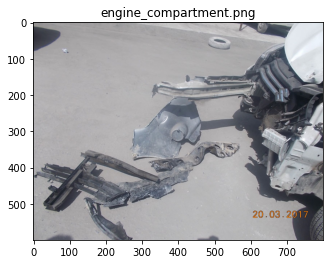

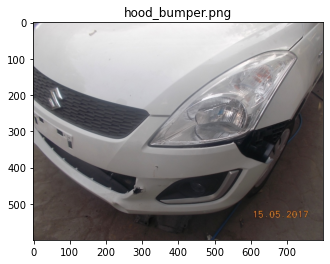

In [131]:
# Test data are stored in ../data directory.
data_dir = "../data"
test_data = !ls {data_dir}/

for d in test_data:
    img = mpimg.imread(f"{data_dir}/{d}")
    plt.imshow(img)
    plt.title(d)
    plt.show()

In order to call the model deployed on Vertex AI, we need to encode image in base64 format to send via API.


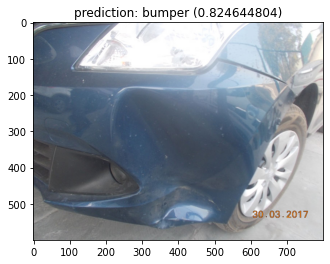

windshield          : 0.000102
lateral             : 0.019668
engine_compartment  : 0.030140
bumper              : 0.824645
hood                : 0.125445
**************************************************


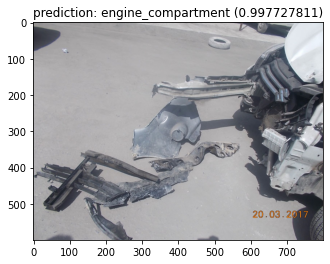

windshield          : 0.000361
lateral             : 0.000073
engine_compartment  : 0.997728
bumper              : 0.001708
hood                : 0.000130
**************************************************


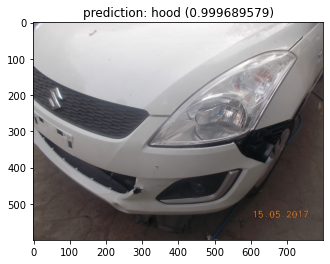

windshield          : 0.000000
lateral             : 0.000060
engine_compartment  : 0.000150
bumper              : 0.000101
hood                : 0.999690
**************************************************


In [132]:
for image in test_data:
    with open(f"../data/{image}", "rb") as f:
        file_content = f.read()

    # encode to base64 and wrap in ImageClassificationPredictionInstance
    encoded_content = base64.b64encode(file_content).decode("utf-8")
    instance = predict.instance.ImageClassificationPredictionInstance(
        content=encoded_content
    ).to_value()

    # call the endpoint
    response = endpoint.predict([instance])

    # extract information from the response
    prediction = response.predictions[0]
    argmax = np.argmax(prediction["confidences"])
    confidence = prediction["confidences"][argmax]
    predicted_label = prediction["displayNames"][argmax]

    # visualize and print out
    img = mpimg.imread(f"../data/{image}")
    plt.imshow(img)
    plt.title(f"prediction: {predicted_label} ({confidence})")
    plt.show()
    for label, confidence in zip(
        prediction["displayNames"], prediction["confidences"]
    ):
        print(f"{label:20}: {confidence:7f}")
    print("*" * 50)

How did your model do? Did it predict all three images correctly?

## Summary
In this lab, you learned how to train your own custom machine learning model and generate predictions on it through the web UI. You uploaded training images to Cloud Storage and used a CSV file for Vertex AI to find these images. You inspected the labeled images for any discrepancies before finally evaluating a trained model. Now you've got what it takes to train a model on your own image dataset.

# License

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.